# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2022W2) 

**Due date: Feb 10, 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- **Be kind** and respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: 
- `fit` can return nothing, 
- `predict` returns an array whose size is the number of examples, 
- `predict_proba` returns an array whose size is the number of examples x 2, and 
- `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        zeros = 0
        ones = 0
        
        for value in y:
            if (value == 1):
                ones += 1
            else:
                zeros += 1
        
        self.ones = ones
        self.zeros = zeros
        return None

    def predict(self, X):
        default_class = 1 if self.ones > self.zeros else 0
        
        return np.full(X.shape[0], default_class)

    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], 2))
        
        total_samples = self.zeros + self.ones
        zero_prob = self.zeros / total_samples
        one_prob = self.ones / total_samples
        
        proba[:, 0] = zero_prob
        proba[:, 1] = one_prob
        
        return proba

    def score(self, X, y):
        predictions = self.predict(X)
        correct = 0
        
        for i, value in enumerate(y):
            if (y[i] == predictions[i]):
                correct += 1
        
        return correct / len(y)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# split the data into the test/train sets using a set random state for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# create the CountVectorizer
countvec = CountVectorizer(stop_words="english")

# create the LogisticRegression 
lr = LogisticRegression(max_iter=1000)

# create the pipeline that first uses the CountVectorizer, then the LogisticRegression model
pipe = make_pipeline(countvec, lr)

# perform and store cross validation using the training set and the pipeline from before
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# view the average of the cross validation results
cross_val_results.mean()

fit_time       0.696216
score_time     0.074583
test_score     0.898475
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. 
    - (Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores.)
- Are the 5 scores close to each other or spread far apart? 
  - (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
cross_val_results["test_score"]

0    0.895587
1    0.898047
2    0.896971
3    0.897893
4    0.903876
Name: test_score, dtype: float64

The scores are close to each other (the difference between the lowest and the highest scores is only 0.008289).
This dataset is a lot larger compared to the  cities dataset we used in class (43352 vs. 209 samples). Since there's more samples for the model to train on, the different folds' scores don't vary as much whereas with a smaller dataset, some folds could have been lucky or unlucky with the training and validation split. 

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
# rerunning the DummyClassifier from before
sk_dc = DummyClassifier(strategy="prior")

sk_dc.fit(X_train, y_train)

cross_val_results = pd.DataFrame(
    cross_validate(sk_dc, X_train, y_train, return_train_score=True)
)

display(cross_val_results["test_score"])
display(cross_val_results.mean())

0    0.735353
1    0.735353
2    0.735353
3    0.735199
4    0.735312
Name: test_score, dtype: float64

fit_time       0.001200
score_time     0.000400
test_score     0.735314
train_score    0.735314
dtype: float64

The DummyClassifier does a lot worse than the logistic regression, so yes, logistic regression seems to be useful. 
CountVectorizer is needed here since the logistic regression requires numerical features cannot handle strings on its own. X_train is the string content of the tweets and needs to be converted first.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [14]:
probabilities = pd.DataFrame(pipe.predict_proba(X_train), index=X_train, columns=pipe.classes_)
tweet = probabilities[True].idxmax()
prob = probabilities[True].max()

print("Most likely to be viral: \n" + tweet)
print(f"Probability: {prob}")

Most likely to be viral: 
“Democrat Texas Congressman Al Green says impeachment is the only thing that can prevent President Trump from re-election in 2020.” @ OANN In other words, Dems can’t win the election fairly. You can’t impeach a president for creating the best economy in our country’s history.....
Probability: 0.9999999602491527


Got the idea of using predict_proba from Lecture 7.

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display
- the 5 words with the highest coefficients and 
- the 5 words with the smallest coefficients.

In [16]:
vocab = list(vec_from_pipe.vocabulary_)
coeff = pd.DataFrame(lr_from_pipe.coef_).T.sort_values(by=0, ascending=False)

print("Words with the 5 highest coefficients")
for i in coeff.iloc[0:5].index:
    print(vocab[i])

print("Words with the 5 lowest coefficients")
for i in coeff.iloc[-5:].index:
    print(vocab[i])

Words with the 5 highest coefficients
e4rbchy3zm
1rpnoeo
newspapers
suhreenaa
jrmcclaren
Words with the 5 lowest coefficients
vincemcmahon
akoya
replay
linsinn
sophocles


Referenced: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

<br><br>

#### 2(f) Running a cross-validation fold without sklearn tools 
rubric={points:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [17]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

In [18]:
X_count = countvec.fit_transform(X_train)
X_train_split, X_validate, y_train_split, y_validate = train_test_split(X_count, y_train, shuffle=False)
lr.fit(X_train_split, y_train_split)

print("Train accuracy:   %0.3f" % lr.score(X_train_split, y_train_split))
print("Test accuracy:   %0.3f" % lr.score(X_validate, y_validate))

Train accuracy:   0.969
Test accuracy:   0.903


Referenced Lectures 3, 6 and 7

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

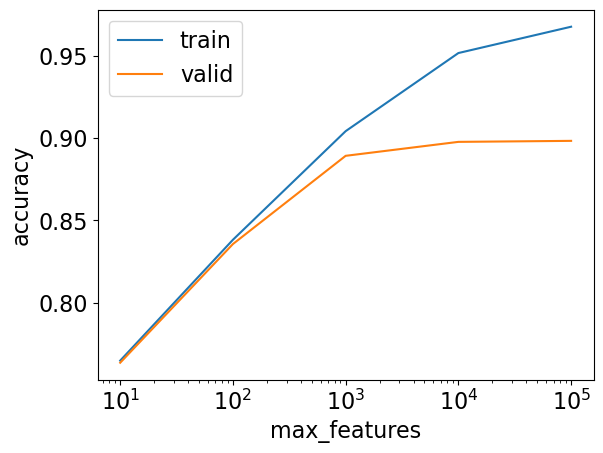

In [19]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [20]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951928,0.897860
4,100000,0.967952,0.898475


Based on the plot, it looks like 100000 max features is the best since the cross validation score doesn't drop, even if the improvement is minimal.

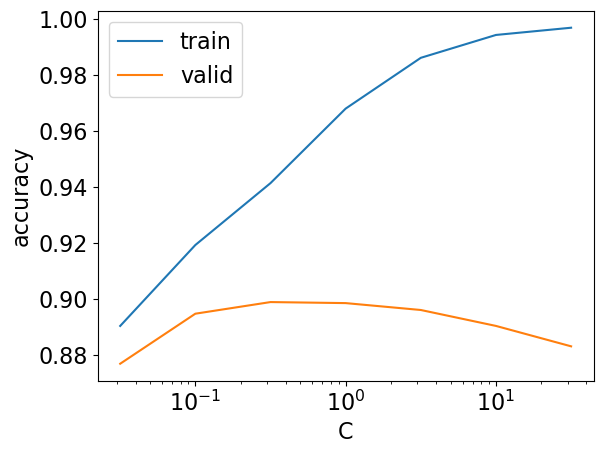

In [19]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, C=C))    
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [ ]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

<br><br>

#### 3(b)
rubric={points:6}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

Based on the plot, what value of `C` seems best?

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

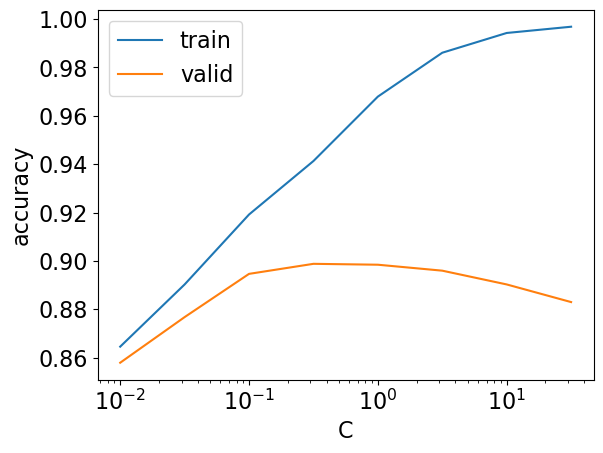

In [21]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [22]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898475
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883035


C=0.316228 seems to be the best. After that, the score for cv falls.

<br><br>

#### 3(c) Hyperparameter optimization 
rubric={points:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? 
- Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [23]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, random_state=123))

param_grid = {
    "countvectorizer__max_features": max_features,
    "logisticregression__C": C_vals,
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

grid_search.fit(X_train, y_train)

best_max_features = grid_search.best_params_["countvectorizer__max_features"]
best_C = grid_search.best_params_["logisticregression__C"]
best_score = grid_search.best_score_

In [24]:
display(best_max_features)
display(best_C)
display(best_score)

100000

0.31622776601683794

0.8988437251093868

According to the grid search, the best values are max_features=100000 and C=0.31622776601683794.

Referenced lecture 8.

<br><br>

#### 3(d) Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3(a) and 3(b)? 
- **Generally speaking**, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

Yes, the best values do agree with what I found earlier. I think it makes sense that these agree with what was found in the earlier questions because those were the values that produced the best results for the separate steps of the pipeline.

#### 3(e) Test score
rubric={points:2}

- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

In [25]:
pipe = make_pipeline(CountVectorizer(stop_words="english", max_features=best_max_features), LogisticRegression(max_iter=1000, random_state=123, C=best_C))
pipe.fit(X_train, y_train)
test_score = pipe.score(X_test, y_test)
test_score

0.9018269053330873

#### 3(f) Discussion of Test Score
rubric={points:4}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

The test accuracy is very similar to the validation accuracy. (second part of question doesn't apply)

## Exercise 4: Very short answer questions
rubric={points:8}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
4. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

1. `fit_transform` as the name suggests, changes the test data that'll be used to train model and may have impacts on the scoring later on.
2. I would prefer being able to access for the access to the probabilities rather than just getting the predicted class
3. `RandomizedSearchCV` is faster that grid search and it's better than the parameters don't all have the same level of importance. 
4. The Golden Rule ensures that we clearly separate the training data and the test data. This is so that we don't contaminate our test results with influences from the test dataset. If we violate it, it will give us a worse classifier when used in real-world situations (and not just on the test and training data that it has access to).

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 